In [ ]:
!pip install qiskit[visualization] --quiet
!pip install qiskit-aer --quiet
!pip install qiskit-experiments
#!pip install matplotlib --quiet
#!pip install numpy --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.5/727.5 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 8.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import qiskit
import matplotlib.pyplot as plt
import qiskit_aer
import warnings
import qiskit_experiments
from qiskit_aer.backends import AerSimulator
from qiskit.quantum_info import Pauli
from qiskit.visualization import plot_histogram
from qiskit_aer.noise import NoiseModel, pauli_error
from qiskit_aer.noise import depolarizing_error

### Exercise 3

In [ ]:
#### Exercise 3 ####

def teleport(Statevector):
  """
  qubit m : Message
  qubit a : Alice
  qubit b : Bob
  """

  # Create circuit
  qm = qiskit.QuantumRegister(1, name = 'qm')
  qa = qiskit.QuantumRegister(1, name = 'qa')
  qb = qiskit.QuantumRegister(1, name = 'qb')
  c0 = qiskit.ClassicalRegister(1, name = 'c0')
  c1 = qiskit.ClassicalRegister(1, name = 'c1')

  circ = qiskit.QuantumCircuit(qm,qa,qb,c0,c1)
  circ.initialize(Statevector, 0)

  # Create EPR state between Alice and Bob
  circ.h(qa)
  circ.cx(qa,qb)

  # Do BSM between initial state and Alice
  circ.cx(qm,qa)
  circ.h(qm)

  # Depending out BSM outcome, apply unitary on Bob to reconstruct state
  circ.measure(qm,c0)
  circ.measure(qa,c1)

  # 00 do nothing

  # 01 apply X
  with circ.if_test((c0,0)):
    with circ.if_test((c1,1)):
        circ.x(qb)
  #circ.x(qb).c_if(c0, 0).c_if(c1, 1)

  # 10 apply Z
  with circ.if_test((c0,1)):
    with circ.if_test((c1,0)):
      circ.z(qb)

  # 11 apply XZ
  with circ.if_test((c0,1)):
    with circ.if_test((c1,1)):
      circ.y(qb)

  return circ


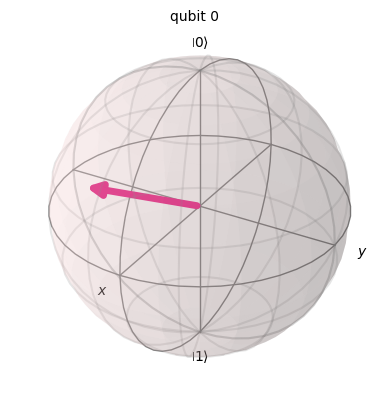

In [ ]:

# Create random state vector
statevec = qiskit.quantum_info.random_statevector(2)

# Create circuit
tp_circ = teleport(statevec)
tp_circ.save_statevector()

#print(tp_circ)
qiskit.visualization.plot_bloch_multivector(statevec)

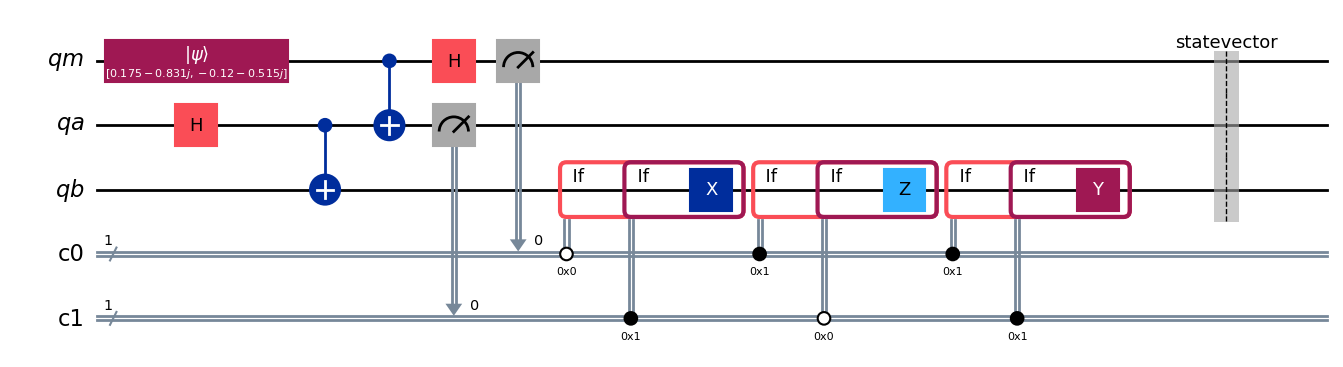

In [ ]:
# Sow circuit
tp_circ.draw('mpl')


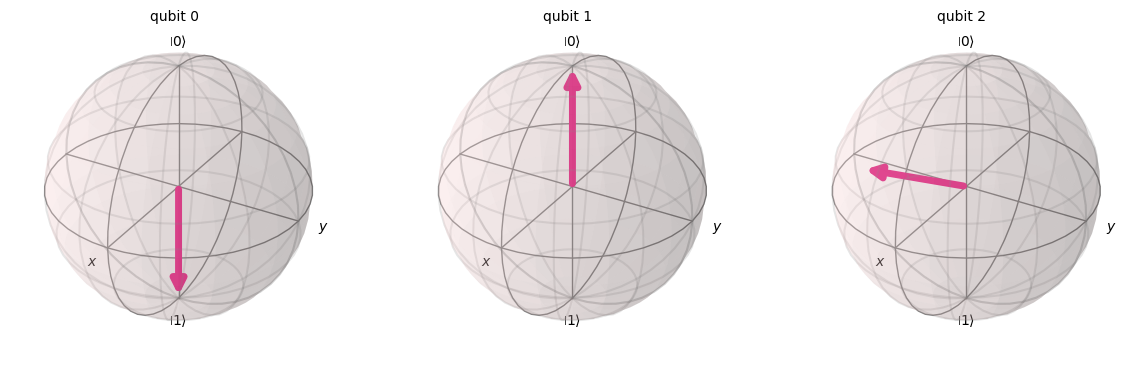

In [ ]:
# Simulate one run of the circuit
sim = AerSimulator()
result = sim.run(tp_circ).result()

# Plot final state vectors
qiskit.visualization.plot_bloch_multivector(result.get_statevector(tp_circ))

### Exercise 8

In [ ]:
circ_8 = qiskit.QuantumCircuit(1)

### Exercise 9

In [ ]:
#### Exercise 9 ####



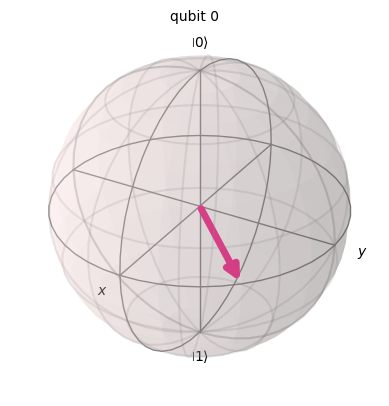

In [ ]:
# Show initial (non-reconstructed) state
circ_init = qiskit.QuantumCircuit(1)
circ_init.h(0)
circ_init.t(0)
circ_init.save_statevector()

# Simulate one run of the circuit
sim = AerSimulator()
statevec = sim.run(circ_init).result().get_statevector(circ_init)

# Plot state vector after TH|0>
qiskit.visualization.plot_bloch_multivector(statevec)

In [ ]:
# Circuit for measuring <sigma_x>
circ_sigma_1 = qiskit.QuantumCircuit(1,1)
circ_sigma_1.initialize(statevec)
circ_sigma_1.h(0)
circ_sigma_1.measure(0,0)

# Circuit for measuring <sigma_y>
circ_sigma_2 = qiskit.QuantumCircuit(1,1)
circ_sigma_2.initialize(statevec)
circ_sigma_2.p(-np.pi/2, 0)
circ_sigma_2.h(0)
circ_sigma_2.measure(0,0)

# Circuit for measuring <sigma_z>
circ_sigma_3 = qiskit.QuantumCircuit(1,1)
circ_sigma_3.initialize(statevec)
circ_sigma_3.measure(0,0)

# Creating simulator
sim = AerSimulator()

# Number of shots
N=500

# sigma_x result
counts1 = sim.run(circ_sigma_1, shots=N).result().get_counts()
r1 = (1/2)*(counts1['0'] - counts1['1'])/N
print(r1)

# sigma_y result
counts2 = sim.run(circ_sigma_2, shots=N).result().get_counts()
r2 = (1/2)*(counts2['0'] - counts2['1'])/N
print(r2)

# sigma_z result
counts3 = sim.run(circ_sigma_3, shots=N).result().get_counts()
r3 = (1/2)*(counts3['0'] - counts3['1'])/N
print(r3)

0.36
0.364
-0.006


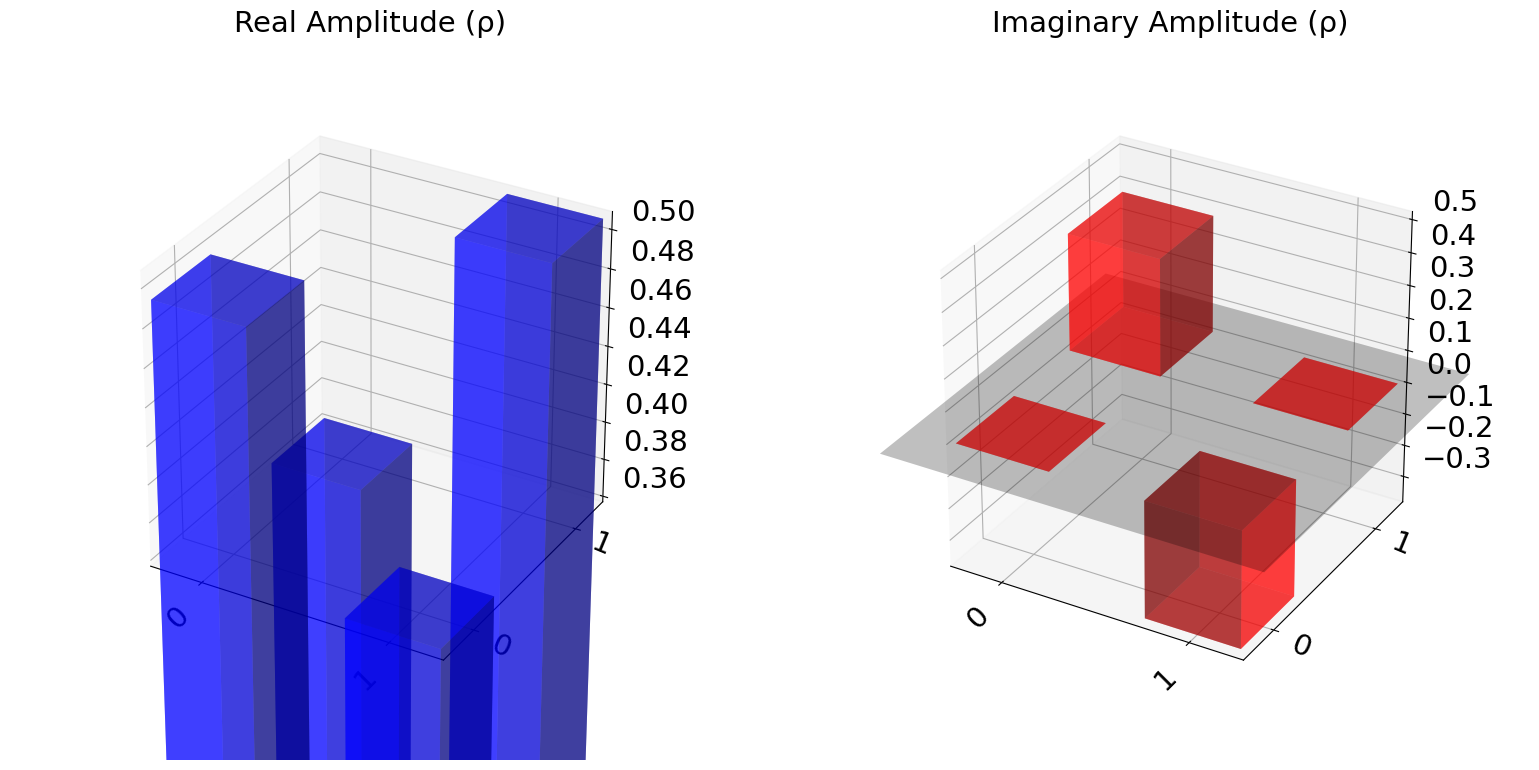

In [ ]:
# State reconstruction
s1 = np.matrix([[0,1],[1,0]])
s2 = np.matrix([[0,-1j],[1j,0]])
s3 = np.matrix([[1,0],[0,-1]])
rho = np.identity(2)/2 + r1 * s1 + r2 * s2 + r3 * s3
# Plot the density matrix
qiskit.visualization.plot_state_city(rho, color=['b', 'r'], alpha=0.5)

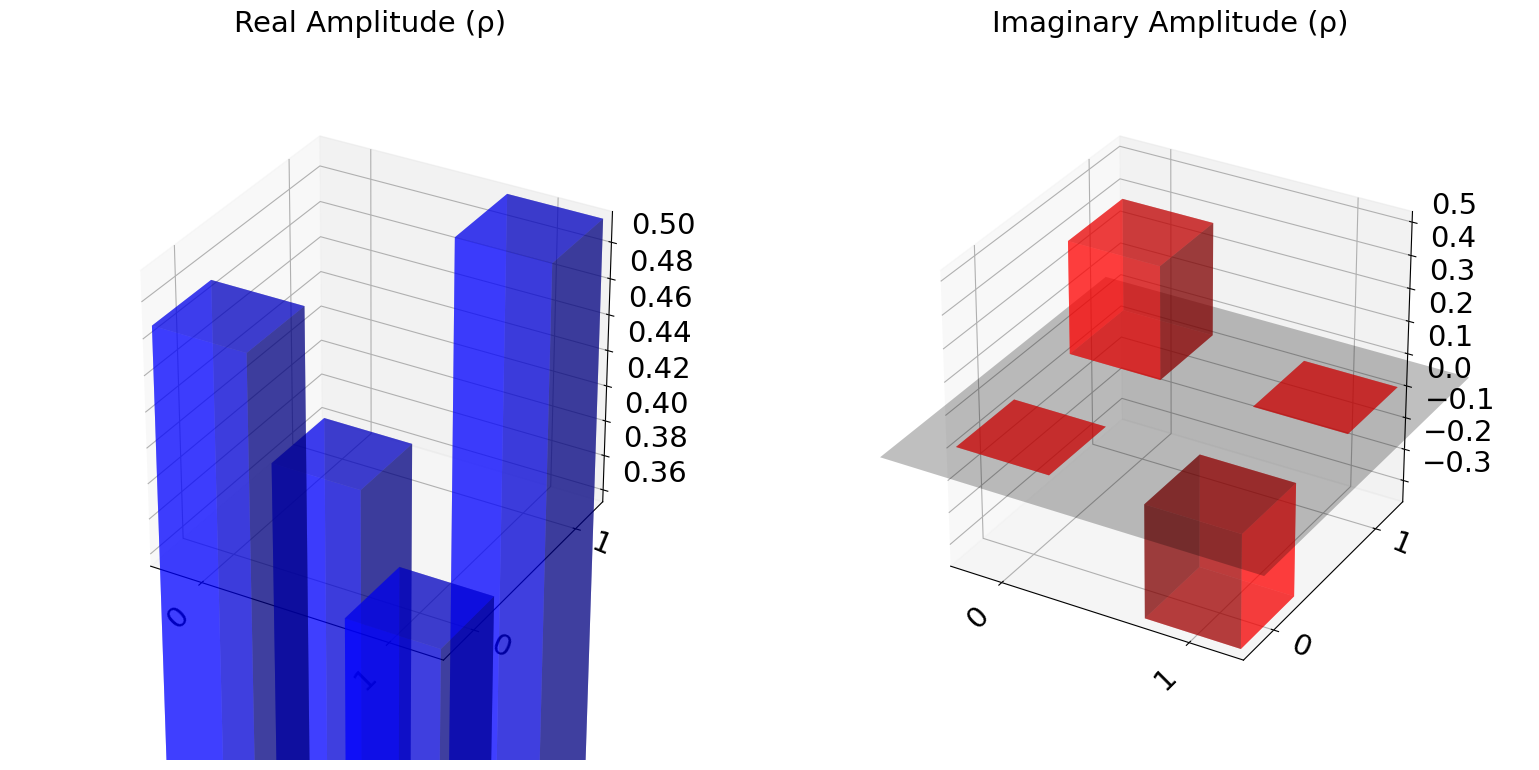

In [ ]:
# Reference result using StateTomography
circ = qiskit.QuantumCircuit(1)
circ.h(0)
circ.t(0)
tomography = qiskit_experiments.library.StateTomography(circ, sim)
reference_state = tomography.run().analysis_results("state").value

# Plot the density matrix
qiskit.visualization.plot_state_city(reference_state, color=['b', 'r'], alpha=0.5)

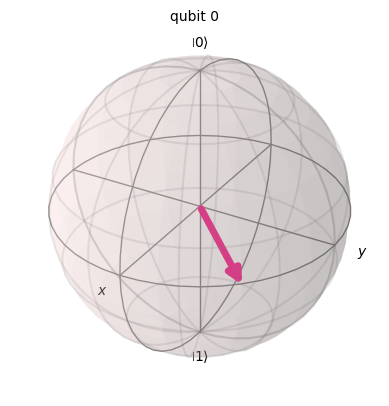

In [ ]:
# Plot the reconstructed state
qiskit.visualization.plot_bloch_multivector(rho)

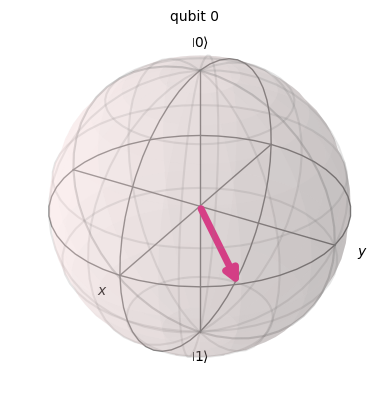

In [ ]:
# Plot reference reconstruction
qiskit.visualization.plot_bloch_multivector(reference_state)

In [ ]:
# Extract the qubit state from the measured density matrix

# This is only meaningful if the state is pure
alpha = np.sqrt(rho[0,0])
phi   = np.angle(rho[0,1]) - np.angle(rho[1,0])
beta  = np.sqrt(rho[1,1])*np.exp(1j*phi)

print(f"The recoverered state is {alpha}|0> + {beta}|1>")
print(f"Sum of the coefficients: {np.abs(alpha)**2 + np.abs(beta)**2}, we expect 1")

The recoverered state is (0.7028513356322231+0j)|0> + (-0.007859834889503623-0.7112933452489977j)|1>
Sum of the coefficients: 1.0, we expect 1


### Exercise 10

In [ ]:
#### Exercise 10 ####

def time_evolve(circ,t,dt,w,w0,w1):
    """Applying the time evolution operator `U` to the circuit `circ`."""
    # if not np.isclose(t/dt,int(t/dt)): warnings.warn("dt does not divide t!")

    N = int(t/dt)

    for iTrotter in range(N):
        theta_z = -w0 * dt
        theta_x = 2 * w1 * dt * np.cos(w * iTrotter * dt)
        circ.rx(theta_x,0)
        circ.rz(theta_z,0)

    return circ

In [ ]:
w0 = 25
w1 = 2
w = 25.5
dt = 0.05
nShots = 300

# range of t : [0,4]
ts = np.linspace(0,4,int((4/dt)))
alphas = np.zeros(ts.shape[0],dtype=np.complex_)
betas = np.zeros(ts.shape[0],dtype=np.complex_)

# noisy simulator
p = 0.1
gamma = 0.02
GAD = qiskit_aer.noise.amplitude_damping_error(gamma,p)
noise = qiskit_aer.noise.NoiseModel()
noise.add_all_qubit_quantum_error(error=GAD,instructions=["rx","rz"])
sim_noise = qiskit_aer.AerSimulator(noise_model=noise)

for i,t in enumerate(ts):
    circ = qiskit.QuantumCircuit(1,1)
    # adding the time evolution
    circ = time_evolve(circ,t,dt,w,w0,w1)
    # adding the measurement
    circ.measure(qubit=0,cbit=0)

    # running the noiseless circuit nShots times
    tomography = qiskit_experiments.library.StateTomography(circ, sim)
    state = tomography.run().analysis_results("state").value.data

    alphas[i] = np.sqrt(state[0,0])
    betas[i] = state[1,0] / alphas[i]
    # phi       = np.angle(state[0,1]) - np.angle(state[1,0])
    # betas[i]  = np.sqrt(state[1,1])*np.exp(1j*phi)



/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


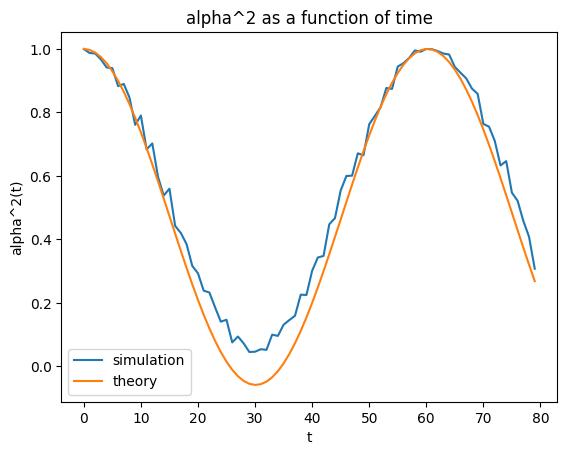

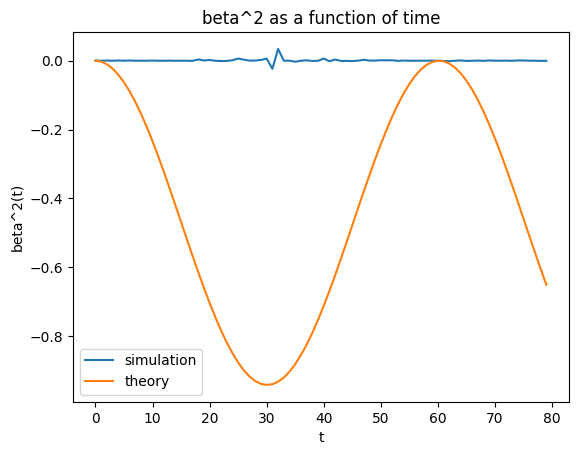

In [ ]:


delta = w - w0
omega = np.sqrt(w1**2 + delta**2)

alpha = lambda t: (np.cos(omega*t/2) - 1j*(delta/omega)*np.sin(omega*t/2))
beta = lambda t: -1j*(w1/omega)*np.sin(omega*t/2)

plt.plot(alphas**2, label="simulation")
plt.plot(alpha(ts)**2, label="theory")
plt.title("alpha^2 as a function of time")
plt.xlabel("t")
plt.ylabel("alpha^2(t)")
plt.legend()

plt.figure()

plt.plot(betas**2, label="simulation")
plt.plot(beta(ts)**2, label="theory")
plt.title("beta^2 as a function of time")
plt.xlabel("t")
plt.ylabel("beta^2(t)")
plt.legend()


In [ ]:
# We observe that while alpha agrees with eq. 4.4, beta does not